In [138]:
#importing library
import numpy as np
import pandas as pd
pd.set_option('max_column',None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report

In [139]:
#loading the dataset
df=pd.read_csv('../input/apartment-rental-offers-in-germany/immo_data.csv')
df

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.40,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.00,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.90,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,NaN,False,True,0,2.74,10.0,910.0,2016.0,115641081,1.0,geothermal,False,Bayern,True,9.0,820.0,NaN,90.00,Weilheim_Schongau_Kreis,mint_condition,sophisticated,no,no_information,NaN,False,6,roof_storey,82390,3.0,NaN,NaN,NaN,3,False,4,Weilheim_Schongau_Kreis,Eberfing,"Diese schöne, neuwertige Wohnung im Dachgescho...",Fliesen und Parkett. Sichtbarer Dachstuhl.,NaN,NaN,NaN,NaN,NaN,Feb20
268846,Hessen,220.00,gas_heating,NaN,NaN,False,True,12,6.49,NaN,1150.0,1983.0,96981497,1.0,gas,True,Hessen,False,4.0,930.0,NaN,115.00,Bergstraße_Kreis,well_kept,sophisticated,negotiable,no_information,NaN,False,6,apartment,68519,3.5,NaN,1.0,1.0,3,False,5,Bergstraße_Kreis,Viernheim,Hier wird eine Wohnung im 2 Familienhaus angeb...,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",NaN,NaN,2015.0,NaN,NaN,May19
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,NaN,False,True,21,2.90,40.0,930.0,1965.0,66924271,1.0,gas,False,Hessen,True,2.0,650.0,10,95.00,Limburg_Weilburg_Kreis,well_kept,NaN,negotiable,Emsbachstrasse,Emsbachstrasse,False,5,apartment,65552,4.0,160.77,1.0,2.0,4,True,4,Limburg_Weilburg_Krei

In [140]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232236 entries, 0 to 268849
Columns: 1076 entries, serviceCharge to energyEfficiencyClass_missing
dtypes: bool(6), float64(18), int64(9), uint8(1043)
memory usage: 281.9 MB


In [141]:
#one_hot_encoding
def onehotencoding(df,column):
    df=df.copy()
    dummies=pd.get_dummies(df[column],prefix=column)
    df=pd.concat([df,dummies],axis=1)
    df=df.drop(column,axis=1)
    return df

In [144]:
def preprocess_inputs(df):
    df=df.copy()
    #dropping column with high cardinality with high number of missng values
    df=df.drop(['houseNumber','street','streetPlain','regio3','facilities'],axis=1)
    
    #dropping description
    df=df.drop('description',axis=1)
    #drop columsn with 25% missing values
    #missing value columns
    missing_value_columns=df.loc[:,df.isna().mean()>0.25].columns
    df=df.drop(missing_value_columns,axis=1)
    #constructing label columns
    missing_labels=df.loc[df['typeOfFlat'].isna(),:].index
    df=df.drop(missing_labels,axis=0)
    
    df['isApartment']=df['typeOfFlat'].apply(lambda x:1 if x=='apartment' else 0)
    #dropping typeOfFlat columns
    df=df.drop('typeOfFlat',axis=1)
    remaining_na_columns=df.loc[:,df.isna().sum()>0]
    categorical_na_columns=remaining_na_columns.select_dtypes('object').columns
    numeric_na_column=remaining_na_columns.drop(categorical_na_columns,axis=1).columns
    #categorical_columns={column:len(x[column].unique()) for column in x.select_dtypes('object').columns}
    #for column in categorical_columns:
        #df=onehotencoding(df,column)
    for column in numeric_na_column:
        df[column]=df[column].fillna(df[column].mean())
    #filling categorial missing values 
    for column in categorical_na_columns:
        df[column]=df[column].fillna('missing')
    df['date']=pd.to_datetime(df['date'],format='%b%y')
    df['year']=df['date'].apply(lambda x:x.year)
    df['month']=df['date'].apply(lambda x:x.month)
    df=df.drop('date',axis=1)
    #One-hot encode
    for column in df.select_dtypes('object'):
        df=onehotencoding(df,column)
    #scaling the data
    y=df['isApartment']
    x=df.drop('isApartment',axis=1)
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=1)
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x.columns)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)

        
    
    
    
    return x_train,x_test,y_train,y_test

In [145]:
x_train,x_test,y_train,y_test=preprocess_inputs(df)
x_train

serviceCharge  newlyConst   balcony  picturecount  pricetrend  \
0           -0.185058   -0.298941  0.771024      1.568742   -1.684659   
1           -0.274183   -0.298941  0.771024     -0.299177   -0.093462   
2           -0.000257   -0.298941  0.771024     -1.544457   -0.191620   
3            0.027269   -0.298941  0.771024     -0.766157   -0.207119   
4           -0.090690   -0.298941 -1.296977     -0.299177    0.707304   
...               ...         ...       ...           ...         ...   
162560      -0.195544    3.345136  0.771024     -0.143518   -0.258781   
162561      -0.221757   -0.298941 -1.296977      0.012142   -0.728907   
162562      -0.050217    3.345136 -1.296977      0.167802    1.337583   
162563      -0.000257    3.345136  0.771024     -0.143518    0.097689   
162564       0.354935   -0.298941  0.771024     -0.766157    0.263008   

        telekomUploadSpeed  totalRent  yearConstructed   scoutId  hasKitchen  \
0                 0.728683  -0.010576         0.214721  0.437931   -0.745806   
1                 0.728683  -0.009535         0.001652  0.547111   -0.745806   
2                 0.728683  -0.009027         0.001652 -0.085761   -0.745806   
3                -1.239998  -0.007377         0.777060  0.353798   -0.745806   
4                 0.728683  -0.000897        -0.417910 -4.234002   -0.745806   
...                    ...        ...              ...       ...         ...   
162560           -1.738731  -0.000897         1.198814  0.538023   -0.745806   
162561            0.728683  -0.013851        -0.113310 -3.261278   -0.745806   
162562            0.000238   0.003032         1.198814  0.212770   -0.745806   
162563           -1.738731  -0.002934         1.245676  0.696387   -0.745806   
162564           -1.239998  -0.000897         0.636475 -2.358087    1.340831   

          cellar  yearConstructedRange  baseRent  livingSpace      lift  \
0       0.712385             -0.310292 -0.081252    -0.015769 -0.557757   
1       0.712385              0.001082 -0.050950    -0.016383 -0.557757   
2       0.712385              0.001082 -0.015890    -0.033272 -0.557757   
3       0.712385              0.503305 -0.040933    -0.036343 -0.557757   
4       0.712385             -1.123890 -0.069156    -0.045156 -0.557757   
...          ...                   ...       ...          ...       ...   
162560 -1.403735              2.130500  0.012909     0.028144 -0.557757   
162561  0.712385             -0.717091 -0.081001    -0.020989 -0.557757   
162562 -1.403735              2.130500  0.069146    -0.081791  1.792896   
162563 -1.403735              2.130500  0.037952     0.043498  1.792896   
162564 -1.403735              0.503305  0.094299     0.012790 -0.557757   

        baseRentRange   geo_plz   noRooms     floor  noRoomsRange    garden  \
0           -0.838459 -0.769290  0.708068  0.490435      1.501523  1.968415   
1           -0.384050  0.297167 -0.085230  0.490435     -0.632334 -0.508023   
2            0.524768  1.693859 -0.349663 -1.124946     -0.632334 -0.508023   
3            0.070359  0.355347 -0.349663 -0.048025     -0.632334 -0.508023   
4           -0.838459 -0.019191 -0.349663 -0.048025     -0.632334 -0.508023   
...               ...       ...       ...       ...           ...       ...   
162560       0.524768 -0.423422  0.179202 -1.124946      0.434595  1.968415   
162561      -0.838459  1.053876  0.179202 -0.586485      0.434595 -0.508023   
162562       0.979177 -0.932947 -0.349663  1.028895     -0.632334 -0.508023   
162563       0.979177  0.382228  0.179202  0.000052      0.434595  1.968415   
162564       1.433586  1.640683  0.179202 -0.048025      0.434595 -0.508023   

        livingSpaceRange      year     month  regio1_Baden_Württemberg  \
0              -0.083901 -0.185341  1.216695                 -0.257326   
1              -0.083901 -0.185341  1.216695                 -0.257326   
2              -0.083901 -1.673167  0.908902                 -0.257326   
3              -0.083901

In [149]:
inputs=tf.keras.Input(shape=(x_train.shape[1],))
x=tf.keras.layers.Dense(128,activation='relu')(inputs)
x=tf.keras.layers.Dense(128,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model=tf.keras.Model(inputs=inputs,outputs=outputs)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1036)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               132736    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 149,377
Trainable params: 149,377
Non-trainable params: 0
_________________________________________________________________
None


In [152]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ])
history=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)
    ]
    )


2022-03-09 05:31:44.787445: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
4065/4065 [==============================] - 14s 3ms/step - loss: 0.6546 - accuracy: 0.6141 - auc: 0.6453 - val_loss: 0.6418 - val_accuracy: 0.6252 - val_auc: 0.6657
Epoch 2/100
4065/4065 [==============================] - 11s 3ms/step - loss: 0.6192 - accuracy: 0.6521 - auc: 0.7036 - val_loss: 0.6027 - val_accuracy: 0.6679 - val_auc: 0.7259
Epoch 3/100
4065/4065 [==============================] - 12s 3ms/step - loss: 0.5842 - accuracy: 0.6872 - auc: 0.7513 - val_loss: 0.5866 - val_accuracy: 0.6830 - val_auc: 0.7466
Epoch 4/100
4065/4065 [==============================] - 11s 3ms/step - loss: 0.5675 - accuracy: 0.7004 - auc: 0.7686 - val_loss: 0.5743 - val_accuracy: 0.6953 - val_auc: 0.7619
Epoch 5/100
4065/4065 [==============================] - 12s 3ms/step - loss: 0.5549 - accuracy: 0.7092 - auc: 0.7816 - val_loss: 0.5749 - val_accuracy: 0.6959 - val_auc: 0.7631
Epoch 6/100
4065/4065 [==============================] - 12s 3ms/step - loss: 0.5449 - accuracy: 0.7164 - auc:

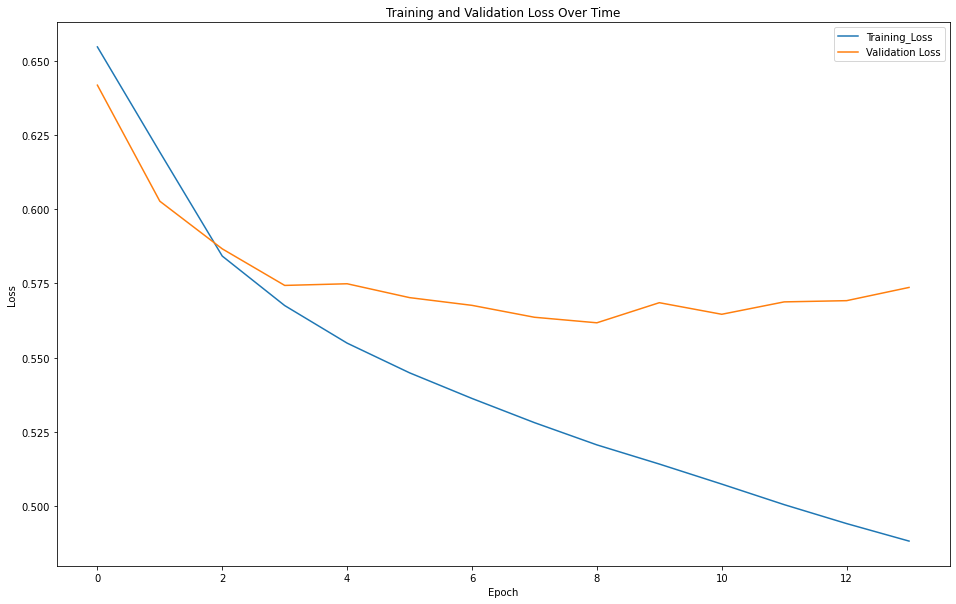

In [153]:
epochs_range=range(len(history.history['loss']))
plt.figure(figsize=(16,10))
plt.plot(epochs_range,history.history['loss'],label='Training_Loss')
plt.plot(epochs_range,history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [154]:
def evaluate_model(model,x_test,y_test):
    results=model.evaluate(x_test,y_test,verbose=0)
    print('Test Loss: {:4f}'.format(results[0]))
    print('Test Accuracy{:2f}%'.format(results[1]*100))
    print("    Test AUC{:4f}".format(results[2]))


In [155]:
evaluate_model(model,x_test,y_test)

Test Loss: 0.562377
Test Accuracy70.822865%
    Test AUC0.778646


In [ ]:
x.describe()

In [ ]:
x['date']

In [ ]:
pd.to_datetime(x['date'],format='%b%y')

In [ ]:
x.isna().sum().sum()

In [ ]:
remaining_na_columns=x.loc[:,x.isna().sum()>0]

In [ ]:
categorical_na_columns=remaining_na_columns.select_dtypes('object').columns
categorical_na_columns

In [ ]:
x.isna().sum().sum()

In [ ]:
df.loc[df['typeOfFlat'].isna(),:].index

In [ ]:
{column:len(x[column].unique()) for column in x.select_dtypes('object').columns}


In [ ]:
x.info()

In [ ]:
x.loc[:,x.isna().mean()>0.25].columns

In [ ]:
x.isna().sum()

In [ ]:
x.info()

In [ ]:
x.iloc[:,x.isna().mean()>0.25]

In [ ]:
#getting information about the dataset
[x.isna().mean()>0.25].columns

In [ ]:
x['typeofflat']